# Manifold Assessment

In this notebook we demonstrate tools that may be used for assessing manifold quality and dimensionality as well as comparing manifolds (parameterizations) in terms of representing dependent variables of interest.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PCAfold import compute_normalized_variance, PCA, normalized_variance_derivative,\
find_local_maxima, plot_normalized_variance, plot_normalized_variance_comparison,\
plot_normalized_variance_derivative, plot_normalized_variance_derivative_comparison, random_sampling_normalized_variance


Here we are creating a two-dimensional manifold to assess with a dependent variable.
Independent variables $x$ and $y$ and dependent variable $f$ will be defined as

\begin{align}
  x &= e^{g} \cos^2(g) \\
  y &= \cos^2(g) \\
  f &= g^3+g \\
\end{align}
for a grid $g$ between [-0.5,1].



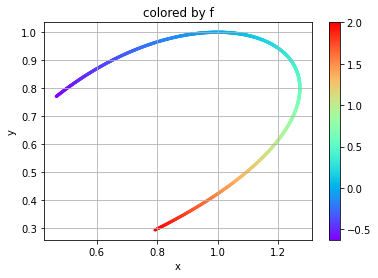

In [2]:
npts = 1001
grid = np.linspace(-0.5,1.,npts)

x = np.exp(grid)*np.cos(grid)**2
y = np.cos(grid)**2

f = grid**3+grid
depvar_name = 'f' # dependent variable name

plt.scatter(x, y, c=f, s=5, cmap='rainbow')
plt.colorbar()
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('colored by f')
plt.show()


We now want to assess the manifold in one and two dimensions using `compute_normalized_variance`. In order to use this function, the independent and dependent variables must be arranged into two-dimensional arrays size npts by number of variables. This is done in the following code.

In [3]:
indepvars = np.vstack((x, y)).T
depvars = np.expand_dims(f, axis=1)
print('indepvars shape:', indepvars.shape, '\n  depvars shape:', depvars.shape)


indepvars shape: (1001, 2) 
  depvars shape: (1001, 1)


We can now call `compute_normalized_variance` on both the two-dimensional manifold and one-dimensional slices of it in order to assess the true dimensionality of the manifold (which should be two in this case).
A normalized variance is computed at various bandwidths (Gaussian kernel filter widths) which can provide indications of overlapping states in the manifold (or non-uniqueness) as well as indications of how spread out the dependent variables are. A unique manifold with large spread in the data should better facilitate building models for accurate representations of the dependent variables of interest. Details on the normalized variance equations may be found in the documentation. 

The bandwidths are applied to the independent variables after they are centered and scaled inside a unit box (by default). The bandwidth values may be computed by default according to interpoint distances or may be specified directly by the user.

Below is a demonstration of using default bandwidth values and plotting the resulting normalized variance.


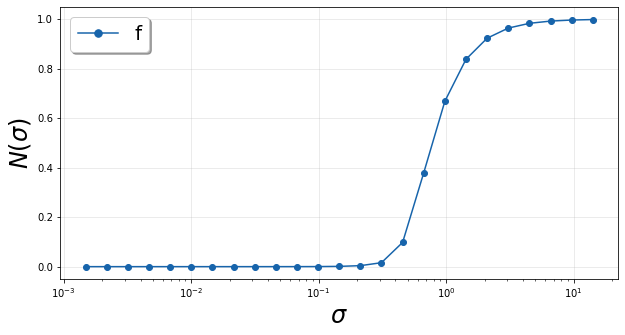

In [16]:
orig2D_default  = compute_normalized_variance(indepvars, depvars, [depvar_name])

plt = plot_normalized_variance(orig2D_default)
plt.show()


Now we will define an array for the bandwidths in order for the same values to be applied to our manifolds of interest.


In [5]:
bandwidth = np.logspace(-6,1,100) # array of bandwidth values

# one-dimensional manifold represented by x
orig1Dx = compute_normalized_variance(indepvars[:,:1], depvars, [depvar_name], bandwidth_values=bandwidth)
# one-dimensional manifold represented by y
orig1Dy = compute_normalized_variance(indepvars[:,1:], depvars, [depvar_name], bandwidth_values=bandwidth)
# original two-dimensional manifold
orig2D  = compute_normalized_variance(indepvars,       depvars, [depvar_name], bandwidth_values=bandwidth)


The following plot shows the normalized variance calculated for the dependent variable on each of the three manifolds. A single smooth rise in the normalized variance over bandwidth values indicates a unique manifold. Multiple rises, as can be seen in the one-dimensional manifolds, indicate multiple scales of variation. In this example, those smaller scales can be attributed to non-uniqueness introduced through the projection into one dimension. A curve that rises at larger bandwidth values also indicates more spread in the dependent variable over the manifold. Therefore the desired curve for an optimal manifold is one that has a single smooth rise that occurs at larger bandwidth values.


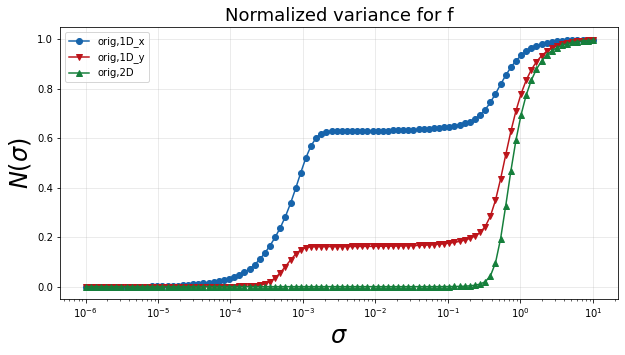

In [17]:
plt = plot_normalized_variance_comparison((orig1Dx, orig1Dy, orig2D), ([], [], []), ('Blues', 'Reds', 'Greens'), title='Normalized variance for '+depvar_name)
plt.legend(['orig,1D_x', 'orig,1D_y', 'orig,2D'])
plt.show()


In order to better highlight the fastest changes in the normalized variance, we look at a scaled derivative over the logarithmically scaled bandwidths which relays how fast the variance is changing as the bandwidth changes. Specifically we compute $\hat{\mathcal{D}}(\sigma)$, whose equation can be found in the documentation. Below we show this quantity for the original two-dimensional manifold.

We see a single peak in $\hat{\mathcal{D}}(\sigma)$ corresponding to the single rise in $\mathcal{N}(\sigma)$ pointed out above. The location of this peak gives an idea of the feature sizes or length scales associated with variation in the dependent variable over the manifold.


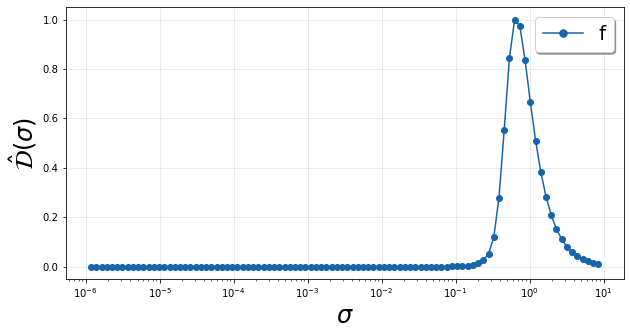

In [7]:
plt = plot_normalized_variance_derivative(orig2D)
plt.show()


We can also plot a comparison of these peaks using `plot_normalized_variance_derivative_comparison` for the three manifold representations discussed thus far. In the plot below, we can see that the two one-dimensional projections have two peaks in $\hat{\mathcal{D}}(\sigma)$ corresponding to the two humps in the normalized variance. This clearly shows that the projections are introducing a significant scale of variation not present on the original two-dimensional manifold. The locations of these peaks indicate the feature sizes or scales of variaiton present in the dependent variable on the manifolds.

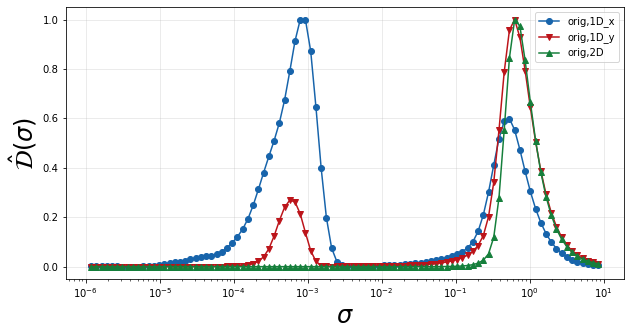

In [8]:
plt = plot_normalized_variance_derivative_comparison((orig1Dx, orig1Dy, orig2D), ([],[],[]), ('Blues', 'Reds','Greens'))
plt.legend(['orig,1D_x', 'orig,1D_y', 'orig,2D'])
plt.show()


We can also break down the analysis of these peaks to determine the $\sigma$ where they occur. The `normalized_variance_derivative` function will return a dictionary of $\hat{\mathcal{D}}(\sigma)$ for each dependent variable along with the corresponding $\sigma$ values. The `find_local_maxima` function can then be used to report the locations of the peaks in $\hat{\mathcal{D}}(\sigma)$ along with the peak values themselves. In order to properly analyze these peaks, we leave the `logscaling` parameter to its default True value. We can also set `show_plot` to True to display the peaks found. This is demonstrated for the one-dimensional projection onto x below.

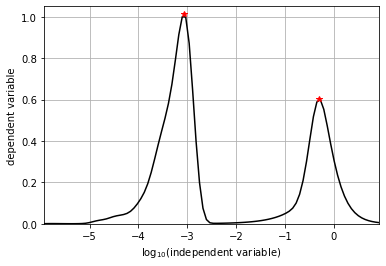

peak locations: [0.00086033 0.5070298 ]
peak values: [1.01351778 0.60217727]


In [9]:
orig1Dx_derivative, orig1Dx_sigma = normalized_variance_derivative(orig1Dx)
orig1Dx_peak_locs, orig1Dx_peak_values = find_local_maxima(orig1Dx_derivative[depvar_name], orig1Dx_sigma, show_plot=True)
print('peak locations:', orig1Dx_peak_locs)
print('peak values:', orig1Dx_peak_values)


In this example, we know in the case of the one-dimensional projections that non-uniqueness or overlap is introduced in the dependent variable representation. This shows up as an additional peak in $\hat{\mathcal{D}}(\sigma)$ compared to the original two-dimensional manifold. In general, though, we may not know whether that additional scale of variation is due to non-uniqueness or is a new characteristic feature from sharpening gradients. We can analyze sensitivity to data sampling in order to distinguish between the two. 

As an example, we will analyze the projection onto x. We can use the `random_sampling_normalized_variance` to compute the normalized variance for various random samplings based on the provided `sampling_percentages` argument. We can also specify multiple realizations through the `n_sample_iterations` argument, which will be averaged for returning $\hat{\mathcal{D}}(\sigma)$. We will test 100%, 50%, and 25% specified as [1., 0.5, 0.25]. Note that specifying 100% returns the same result as calling compute_normalized variance on the full dataset as we did above.


In [10]:
pctdict, pctsig, _ = random_sampling_normalized_variance([1., 0.5, 0.25], 
                                                             indepvars[:,:1], 
                                                             depvars, 
                                                             [depvar_name],
                                                             bandwidth_values=bandwidth,
                                                             n_sample_iterations=5)


sampling 100.0 % of the data
  iteration 1 of 5
  iteration 2 of 5
  iteration 3 of 5
  iteration 4 of 5
  iteration 5 of 5
sampling 50.0 % of the data
  iteration 1 of 5
  iteration 2 of 5
  iteration 3 of 5
  iteration 4 of 5
  iteration 5 of 5
sampling 25.0 % of the data
  iteration 1 of 5
  iteration 2 of 5
  iteration 3 of 5
  iteration 4 of 5
  iteration 5 of 5


We then plot the result below and report the peak locations for the two dominant peaks. We can see that the peak at the larger $\sigma$ isn't very sensitive to data sampling. It remains around 0.5. The peak at smaller $\sigma$ though experiences a shift to larger $\sigma$ as less data is included (lower percent sampling). This is because variation from non-uniqueness is much more sensitive to data spacing than characteristic feature variation. We would therefore conclude that the second scale of variation introduced by the projection onto x is due to non-uniqueness, not a characteristic feature size, and therefore the projection is unacceptable. This confirms what we already knew from the visual analysis.

100% sampling peak locations ordered by height: 8.60e-04, 5.07e-01
 50% sampling peak locations ordered by height: 1.15e-03, 5.06e-01
 25% sampling peak locations ordered by height: 3.68e-03, 4.98e-01


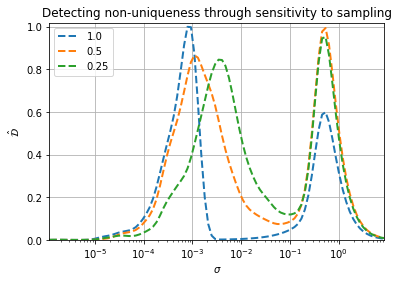

In [11]:
peakthreshold = 0.4

for pct in pctdict.keys():
    plt.semilogx(pctsig, pctdict[pct][depvar_name], '--', linewidth=2, label=pct)
    peak_locs, peak_vals = find_local_maxima(pctdict[pct][depvar_name], pctsig, threshold=peakthreshold)
    print(f'{pct*100:3.0f}% sampling peak locations ordered by height: {peak_locs[0]:.2e}, {peak_locs[1]:.2e}')

plt.grid()
plt.xlabel('$\sigma$')
plt.ylabel('$\hat{\mathcal{D}}$')
plt.legend()
plt.xlim([np.min(pctsig), np.max(pctsig)])
plt.ylim([0,1.02])
plt.title('Detecting non-uniqueness through sensitivity to sampling')
plt.show()


As an example of comparing multiple representations of a manifold in the same dimensional space, we will use PCA. Below, two pca objects are created with different scalings. The first uses the default scaling `std` while the second uses the scaling `pareto`. The plots of the resulting manifolds are shown below for comparison to the original. The dimensions for the PCA manifolds are referred to as PC1 and PC2.

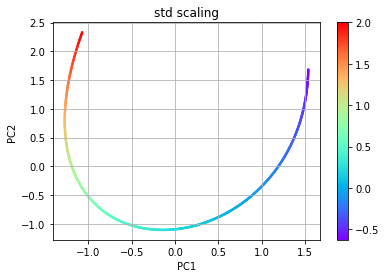

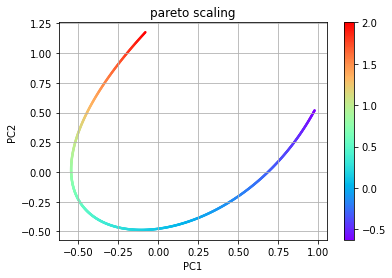

In [12]:
# PCA using std scaling
pca_std = PCA(indepvars)
eta_std = pca_std.transform(indepvars)

plt.scatter(eta_std[:,0], eta_std[:,1], c=f, s=2, cmap='rainbow')
plt.colorbar()
plt.grid()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('std scaling')
plt.show()

# PCA using pareto scaling
pca_pareto = PCA(indepvars,'pareto')
eta_pareto = pca_pareto.transform(indepvars)

plt.scatter(eta_pareto[:,0], eta_pareto[:,1], c=f, s=2, cmap='rainbow')
plt.colorbar()
plt.grid()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('pareto scaling')
plt.show()


We call `compute_normalized_variance` in order to assess these manifolds in one and two dimensional space. Since PCA orders the PCs according the amount of variance explained, we will use PC1 for representing a one-dimensional manifold.

In [13]:
pca1D_std = compute_normalized_variance(eta_std[:,:1], depvars, [depvar_name],bandwidth_values=bandwidth)
pca2D_std = compute_normalized_variance(eta_std,       depvars, [depvar_name],bandwidth_values=bandwidth)

pca1D_pareto = compute_normalized_variance(eta_pareto[:,:1], depvars, [depvar_name],bandwidth_values=bandwidth)
pca2D_pareto = compute_normalized_variance(eta_pareto,       depvars, [depvar_name],bandwidth_values=bandwidth)


We then go straight to plotting $\hat{\mathcal{D}}$ to see if new peaks are introduced compared to the original two-dimensional manifold, indicating new scales of variation. We again find that the one-dimensional projections are introducing a new scale. We could perform a similar analysis as shown above on the projection onto x to conclude that these new scales are also from non-uniqueness introduced in the projection. We therefore continue the analysis only considering two-dimensional parameterizations to figure out which one may be best in representing f.

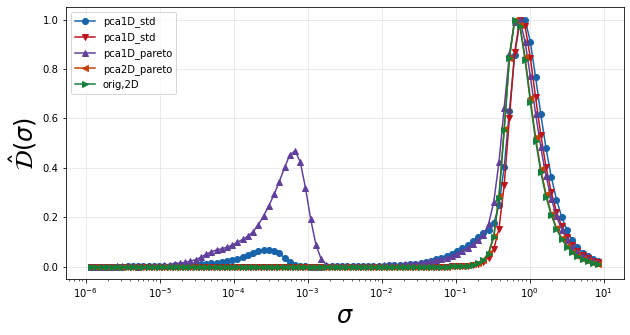

In [14]:
plt = plot_normalized_variance_derivative_comparison((pca1D_std, pca2D_std, pca1D_pareto, pca2D_pareto, orig2D), 
                                                     ([],[],[],[],[]), 
                                                     ('Blues', 'Reds', 'Purples', 'Oranges', 'Greens'))
plt.legend(['pca1D_std', 'pca1D_std', 'pca1D_pareto', 'pca2D_pareto', 'orig,2D'])
plt.show()


We compute the locations of the peaks in $\hat{\mathcal{D}}$ over $\sigma$ below.

In [15]:
pca2D_std_derivative, pca2D_std_sigma  = normalized_variance_derivative(pca2D_std)
pca2D_pareto_derivative, pca2D_pareto_sigma  = normalized_variance_derivative(pca2D_pareto)
orig2D_derivative,  orig2D_sigma  = normalized_variance_derivative(orig2D)

pca2D_std_peak_locs, _ = find_local_maxima(pca2D_std_derivative[depvar_name], pca2D_std_sigma)
pca2D_pareto_peak_locs, _ = find_local_maxima(pca2D_pareto_derivative[depvar_name], pca2D_pareto_sigma)
orig2D_peak_locs, _ = find_local_maxima(orig2D_derivative[depvar_name], orig2D_sigma)

print('peak locations:')
print('orig2D',orig2D_peak_locs)
print('pca2D_std',pca2D_std_peak_locs)
print('pca2D_pareto',pca2D_pareto_peak_locs)


peak locations:
orig2D [0.66762295]
pca2D_std [0.78185085]
pca2D_pareto [0.67063695]


The results show that PCA with `std` scaling results in the largest feature size (largest $\sigma$) and is therefore the best for parameterizing f. This representation should better facilitate modeling of f as the features are more spread out.